<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

# First steps towards the numerical treatment of ODEs

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import plot_functions.plot_settings

## Starting with a Game

**Group 1:** Algebraic instructions

**Group 2:** Differential instructions

A person is placed randomly on the map. Your task is to guide it using instructions as per your group.

**Task a):** Guide the person to the highest peak.

**Task b):** Guide the person to the peak of the nearest mountain.

Compare the solution strategies in terms of information needed by the person to succeed, efficiency of the solution, generality of the solution method.

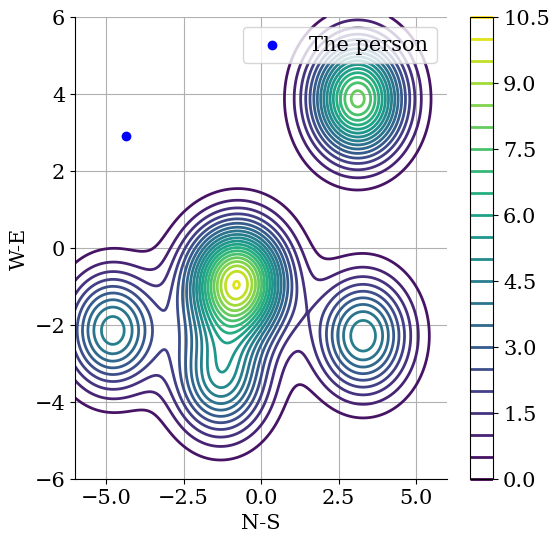

In [10]:
def smoother_quadratic_maxima_function(x, y, x_max, y_max, z_max):
    Z = np.zeros_like(x)
    for i in range(len(x_max)):
        Z += z_max[i] * np.exp(-0.5*((x - x_max[i])**2 + (y - y_max[i])**2))     
    return Z


x_max = np.random.uniform(-5, 5, 6)
y_max = np.random.uniform(-5, 5, 6)
z_max = np.random.uniform(2, 10, 6)

x = np.linspace(-6, 6, 400)
y = np.linspace(-6, 6, 400)
X, Y = np.meshgrid(x, y)

Z = smoother_quadratic_maxima_function(X, Y, x_max, y_max, z_max)

blue_point_x = np.random.uniform(-6, 6)
blue_point_y = np.random.uniform(-6, 6)


plt.figure(figsize=(6,6))
contour = plt.contour(X, Y, Z, 20, cmap='viridis') 
plt.colorbar(contour)
plt.scatter(blue_point_x, blue_point_y, color='blue', label=r"The person")
plt.grid(True)
plt.xlabel(r"N-S")
plt.ylabel(r"W-E")
plt.legend()
plt.show()

## From algebraic and differential equations

Consider a pore pressure profile given algebraically by:

$$
    p(x) = p_0 + (p_1 - p_0) \left( \frac{x}{L} \right)^2 \quad x \in [0, L]
$$

In [11]:
p = lambda p0, p1, xi: p0 + (p1 - p0) * xi**2

In [12]:
xi = np.linspace(0,1,100)

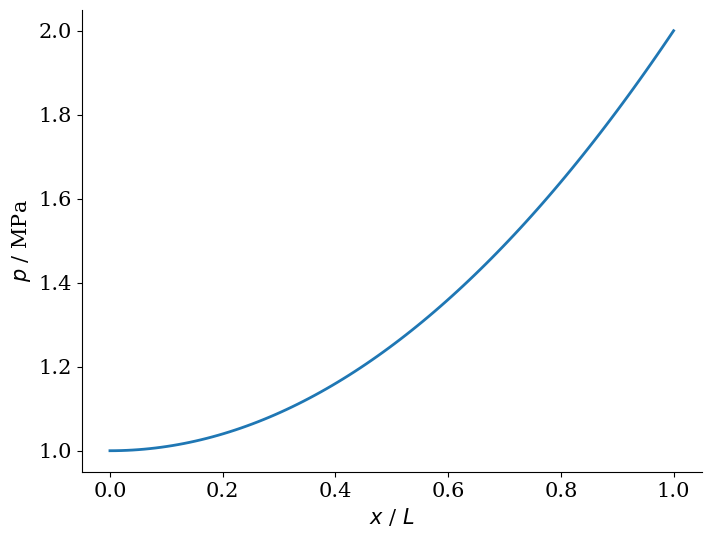

In [13]:
fig, ax = plt.subplots()
ax.plot(xi,p(1,2,xi))
ax.set_xlabel(r'$x$ / $L$')
ax.set_ylabel(r'$p$ / MPa');

Usually, however, we understand how systems change due to acting forces, fluxes, etc. Looking at changes rather than absolute expressions one arrives at differential equations. Here, for illustration, we follow the opposite logic and derive our algebraic pressure profile:

$$
    p'=\frac{\mathrm{d}p}{\mathrm{d}x} = 2 (p_1 - p_0) \left( \frac{x}{L} \right)
$$

We notice that this equation describes pressure *changes*. The constant offset $p_0$ is lost upon differentiation. This information, the point of departure of an ODE, needs to be added in the form of an initial or boundary condition. This is equivalent to a treasure map with instructions of the type "100 paces north, 70 paces west, ..." -- to find the treasure, you need to know the point of departure. Let's illustrate this:

In [14]:
dp_dx = lambda p0, p1, xi: 2 * (p1 - p0) * xi

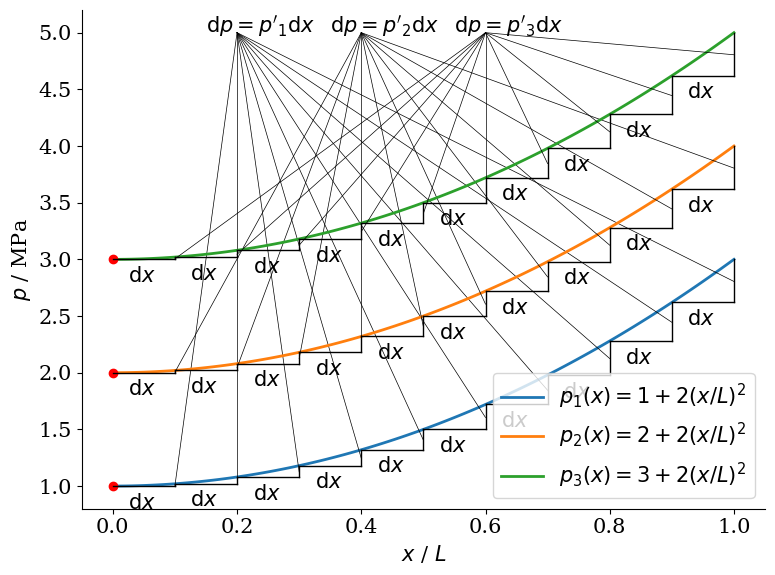

In [15]:
fig, ax = plt.subplots()

for p0 in [1,2,3]:
    ax.plot(xi,p(p0,p0+2,xi),label=r'$p_{%i}(x) = %i + 2 (x/L)^2$' %(p0,p0))
    ax.plot(0,p0,marker='o',color='red')
    x = 0
    dx = 0.1
    while x+dx < 1:
        ax.plot([x,x+dx],[p(p0,p0+2,x),p(p0,p0+2,x)],color='black',lw=1)
        ax.plot([x+dx,x+dx],[p(p0,p0+2,x),p(p0,p0+2,x+dx)],color='black',lw=1)
        ax.text(x+dx/4,p(p0,p0+2,x)-0.2,r'$\mathrm{d}x$')
        ax.plot([x+dx,0.2*p0],[p(p0,p0+2,x+dx/2),5],color='black',lw=0.5)
        x = x + dx
    ax.text(0.2*p0-0.05,5,r"$\mathrm{d}p = p'_{%i} \mathrm{d}x$" %(p0))
ax.set_xlabel(r'$x$ / $L$')
ax.set_ylabel(r'$p$ / MPa')
ax.legend()
fig.tight_layout();

## A more meaningful example: earth pressure with silo effects

We assume a cylindrical setting and the full mobilisation of wall friction.

Collecting all acting forces and demanding vertical equilibrium of forces:

$$
    \downarrow: \quad \sigma_{zz} \pi r^2 - \left( \sigma_{zz} + \frac{\partial \sigma_{zz}}{\partial z}\text{d}z \right) \pi r^2 + \gamma \pi r^2 \text{d}z - K_0 \sigma_{zz} \tan \delta_\text{s} 2\pi r \text{d}z= 0
$$

Rearranging ... 

$$
    0 = \left( -\frac{\partial \sigma_{zz}}{\partial z} r + \gamma r - 2 K_0 \sigma_{zz} \tan\delta_\text{s}  \right) \pi r \text{d} z
$$

... meaningful solution once term in brackets vanishes. Rearranging a bit again ....

$$
    \frac{\text{d}\sigma_{zz}}{\text{d}z} = \gamma - \frac{2 K_0 \sigma_{zz} \tan \delta_\text{s}}{r}
$$

This is a non-homogeneous, ordinary differential equation of first order with (so far) constant coefficients.

**Tasks:**

- Check the plausibility in terms of $\gamma$, $K_0$, $\tan \delta_\text{s}$ and $r$.
- What is expected to happen with the stress increase at a certain depth?

### Analytical solution

Integration can proceed by separation of variables. We assume that the top surface is unloaded, i.e. $\sigma_{zz}(z=0) = 0$.

\begin{align}
    &\int \limits_{0}^{\sigma_{zz}} \frac{\text{d}\bar{\sigma}_{zz}}{\displaystyle \gamma - \frac{2 K_0 \bar{\sigma}_{zz} \tan \delta_\text{s}}{r}} = \int \limits_{0}^{z}\text{d}\bar{z}
    \\
    & \left. -\frac{r}{2 K_0 \tan\delta_\text{s}} \ln \left( \gamma - \frac{2 K_0 \bar{\sigma}_{zz} \tan \delta_\text{s}}{r} \right) \right|_0^{\sigma_{zz}} = z
    \\
    & \ln \left(\frac{\gamma r - 2 K_0 \sigma_{zz} \tan \delta_\text{s}}{\gamma r} \right) = -2 K_0 \tan\delta_\text{s} \frac{z}{r}
\end{align}

Rearranging for $\sigma_{zz}$ yields the sought vertical stress distribution:

$$
    \sigma_{zz} = \frac{\gamma r}{2K_0\tan\delta_\text{s}} \left[ 1 - \exp \left(- 2 K_0 \tan\delta_\text{s} \frac{z}{r} \right) \right]
$$

*Note*: Instead of introducing $r$, one could retain the ratio $u/A$ to approximate non-circular geometries (e.g. rectangular cross sections or forces between walls).

Let's check plausibility by plotting.

In [16]:
sigma = lambda r, K0, mu, gamma, z: gamma*r/(2*K0*mu) * ( 1 - np.exp(-2*K0*mu*z/r))

In [17]:
z = np.linspace(0,20,100)
phi = np.deg2rad(30) #angle of internal friction
tan_ds = np.tan(2/3 * phi) #rough wall
K0 = 1 - np.sin(phi)
gamma = 18. #kN/m³

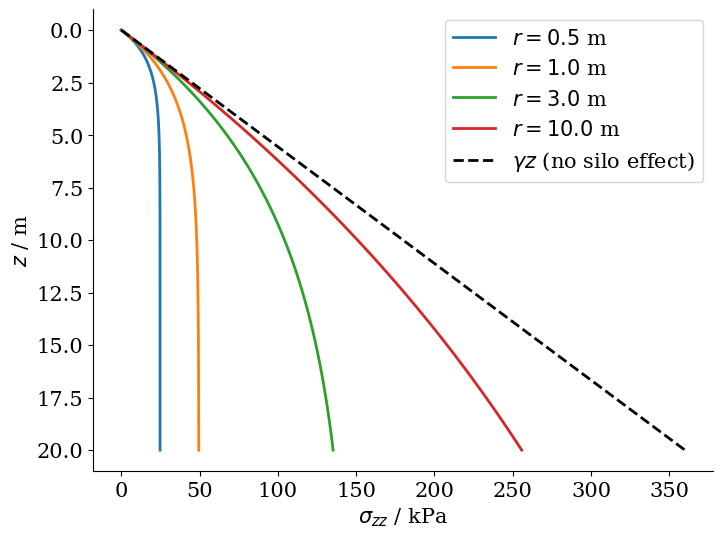

In [18]:
fig, ax = plt.subplots()
for r in [0.5,1,3,10]:
    ax.plot(sigma(r,K0,tan_ds,gamma,z),z,label=r'$r = %.1f$ m' %r)
ax.plot(gamma*z,z,ls='--',color='black',label=r'$\gamma z$ (no silo effect)')
ax.set_xlabel(r'$\sigma_{zz}$ / kPa')
ax.invert_yaxis()
ax.set_ylabel(r'$z$ / m')
ax.legend();

The limiting stress value can be read off the differential equation as well as the integration result as

$$
    \sigma_{zz}^\text{lim} = \frac{\gamma r}{2K_0\tan\delta_\text{s}}
$$


**Tasks:**

Assuming again $K_0 = 1 - \sin \varphi$ and $\tan\delta_\text{s} = \tan 2\varphi/3$, generate the following graphs:

- Limiting stress value as a function of the radius for different friction angles.
- Determine the depth at which 99\,\% of the limiting stress value are achieved.
- Plot the horizontal earth pressure curves $e_\text{h}$

## Numerical integration

We depart again from the ODE

$$
    \frac{\text{d}\sigma_{zz}}{\text{d}z} = \gamma - \frac{2 K_0 \sigma_{zz} \tan \delta_\text{s}}{r}
$$

In [19]:
dsig_dz = lambda r, K0, mu, gamma, sig_zz: gamma - (2*K0*mu*sig_zz) / r

As a first naive approach for the integration of this equation, we divide the subsurface up to the depth of interest into small slices $\Delta z$. While $\text{d}z$ and $\text{d}\sigma_{zz}$ are infinitesimal, $\Delta z$ is a finite step producing a finite stress increment $\Delta \sigma_{zz}$. Thus, we replace the differential / infinitesimal difference quotient by a finite difference quotient:

$$
    \frac{\Delta\sigma_{zz}}{\Delta z} = \gamma - \frac{2 K_0 \sigma_{zz} \tan \delta_\text{s}}{r}
$$

We could now come up with the following update procedure, departing from a starting value $\sigma_0$:

\begin{alignat}{3}
    &&z_0&:\ \sigma_0
    \\
    &&z_1 = z_0 + \Delta z &:\ \sigma_1 = \sigma_0 + \Delta \sigma = \sigma_0 +  \left( \gamma - \frac{2 K_0 \sigma_0 \tan \delta_\text{s}}{r} \right) \Delta z
    \\
    &&z_2 = z_1 + \Delta z &:\ \sigma_2 = \sigma_1 + \Delta \sigma = \sigma_1 +  \left( \gamma - \frac{2 K_0 \sigma_1 \tan \delta_\text{s}}{r} \right) \Delta z
    \\
    &&\dots
    \\
    \\
    &&z_{n+1} = z_n + \Delta z &:\ \sigma_{n+1} = \sigma_n + \Delta \sigma = \sigma_n +  \left( \gamma - \frac{2 K_0 \sigma_n \tan \delta_\text{s}}{r} \right) \Delta z
\end{alignat}

As we will see later, this is equivalent to an explicit forward Euler integration scheme. Later, we will also study the effect of the step size. Here, we code the problem naively. Let's go to 20 m depth in steps of one meter:

In [20]:
z_steps = np.linspace(0,20,10)
z_steps

array([ 0.        ,  2.22222222,  4.44444444,  6.66666667,  8.88888889,
       11.11111111, 13.33333333, 15.55555556, 17.77777778, 20.        ])

In [21]:
def integrate_stress(z_steps,r,K0=1-np.sin(np.deg2rad(30)),tds = np.tan(2/3*np.deg2rad(30)), gamma = 18):
    sig_steps = np.copy(z_steps)*0
    for i in range(len(sig_steps)-1):
        sig_steps[i+1] = sig_steps[i] + dsig_dz(r,K0,tds,gamma,sig_steps[i])*(z_steps[i+1]-z_steps[i])
    return sig_steps

0.5 0.3639702342662023 18.0
25.05076385264633
49.45457667949981
139.5870210369407
263.04811150365936


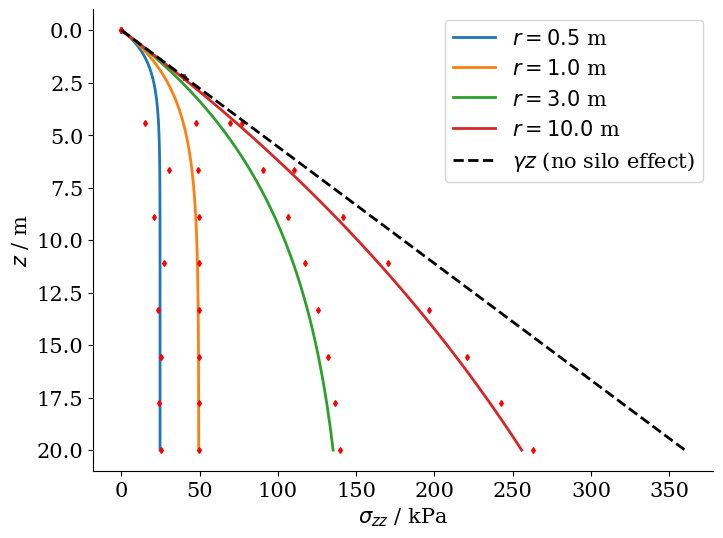

In [22]:
fig, ax = plt.subplots()
print(K0,tan_ds,gamma)
for r in [0.5,1,3,10]:
    ax.plot(sigma(r,K0,tan_ds,gamma,z),z,label=r'$r = %.1f$ m' %r)
    ax.plot(integrate_stress(z_steps,r,K0,tan_ds,gamma),z_steps,ls='',marker='d',color='red',markersize=3)
    print(integrate_stress(z_steps,r,K0,tan_ds,gamma)[-1])
ax.plot(gamma*z,z,ls='--',color='black',label=r'$\gamma z$ (no silo effect)')
ax.set_xlabel(r'$\sigma_{zz}$ / kPa')
ax.invert_yaxis()
ax.set_ylabel(r'$z$ / m')
ax.legend();

**Tasks**

This model has some practical advantages now compared to the analytical solution. Can you think of any?